In [8]:
import pandas as pd 
import numpy as np
import pickle
from collections import defaultdict
import tensorflow as tf

def read_file(filename):
  with open(filename, "rb") as file:
      stat = pickle.load(file)
      file.close()
  return stat

def get_origin_path(stat):
    path_link = stat['data']['paths_link']
    od = [k for k in path_link.keys()]
    path1 = [tuple(p[0]) if len(p) > 0 else np.nan for p in path_link.values()]
    path2 = [tuple(p[1]) if len(p) > 1 else np.nan for p in path_link.values()]
    path3 = [tuple(p[2]) if len(p) > 2 else np.nan for p in path_link.values()]

    demand_dic = stat["data"]["demand"]
    demand = [v for v in demand_dic.values()]
    path_link_df = pd.DataFrame({"od": od, "demand":demand, "path1": path1, "path2": path2, "path3": path3})
    return path_link_df

def get_UE_link_cost(stat, remove_ids=None):
    # return a dataframe of link cost, link flow
    link = stat['data']['network'].copy()

    if remove_ids:
        a = stat['link_flow']
        for index in sorted(remove_ids, reverse=True):
            del a[index]
        link['link_flow'] = a
    else:
        link['link_flow'] = stat['link_flow']
    # Calculate link cost
    link['link_cost'] = round(link['free_flow_time']*\
                            (1+link['b']*((link['link_flow']/link['capacity'])**link['power'])), 2)
    return link

# Calculate path travel time for each od pair
# def calculate_path_cost(row, link_df):
#     if pd.isna(row): 
#         return np.nan
    
#     sum_time = 0
#     for l in row:
#         sum_time += link_df.at[l, 'link_cost']
#     return round(sum_time, 2)

def calculate_path_cost(row, link_df):
    if pd.isna(row): 
        return np.nan
    
    sum_time = 0
    for link in row:
        sum_time += link_df[link_df['link_id']==link]['link_cost'].iloc[0]
    return round(sum_time, 2)

# calculate each link flow based on path flow
def extract_link_flow(path_link, flows):
    # input: a dictionary of {od pair: path_link} and list of flow distribution
    # return a dictionary of link flow
    path_flow = {}
    for path_set, flow_set in zip(path_link.values(), flows):
        for path, flow in zip(path_set, flow_set):
            path_flow[tuple(path)] = flow

    aggregated_sums = defaultdict(float)
    for path, flow in path_flow.items():
        for link in path:
            aggregated_sums[link] += flow
    link_flow = dict(aggregated_sums)
    return link_flow

# Check UE of origin dataset 
def mean_path_cost(filename, remove_ids=None):
    stat = read_file(filename)
    path_link_df = get_origin_path(stat) # get OD pair with demand and paths
    UE_link = get_UE_link_cost(stat, remove_ids)

    path_link_df['path1_cost'] = path_link_df['path1'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path2_cost'] = path_link_df['path2'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path3_cost'] = path_link_df['path3'].apply(lambda x: calculate_path_cost(x, UE_link))

    flows = stat['path_flow']
    path_link_df['flow1'] = [f[0] if len(f)>0 else 0 for f in flows]
    path_link_df['flow2'] = [f[1] if len(f)>1 else 0 for f in flows]
    path_link_df['flow3'] = [f[2] if len(f)>2 else 0 for f in flows]

    mean_path_cost = (np.nanmean(path_link_df['path1_cost']) + np.nanmean(path_link_df['path2_cost']) + np.nanmean(path_link_df['path3_cost']))/3
    return UE_link, path_link_df, mean_path_cost

def sum_pred_link_flow(pred_df, stat):
    pred_path_flow = pred_df[['flow1', 'flow2', 'flow3']].values.tolist()
    path_link = stat['data']['paths_link']

    pred_link_flow = extract_link_flow(path_link, pred_path_flow)
    pred_link_flow = pd.DataFrame.from_dict(pred_link_flow, orient='index', columns=['link_flow']).sort_index(ascending=True).reset_index()
    pred_link_flow.rename(columns={'index': 'link_id'}, inplace=True)
    link = stat['data']['network'].copy()[['link_id', 'capacity', 'free_flow_time', 'b']]
    output = pd.merge(link, pred_link_flow, how='left', on='link_id')
    output = output.fillna(0)
    output['link_cost'] = round(output['free_flow_time']*\
                            (1+output['b']*((output['link_flow']/output['capacity'])**4)), 2)
    return output

def calculate_delay(pred_df, pred_link_flow):
    pred_df['path1_cost'] = pred_df['path1'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path2_cost'] = pred_df['path2'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path3_cost'] = pred_df['path3'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['min_path_cost'] = pred_df[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    # pred_df['delay'] = (
    #     pred_df['flow1'] * (pred_df['path1_cost'] - pred_df['min_path_cost']) +
    #     pred_df['flow2'] * (pred_df['path2_cost'] - pred_df['min_path_cost']) +
    #     pred_df['flow3'] * (pred_df['path3_cost'] - pred_df['min_path_cost'])
    # )
    # avg_delay = pred_df['delay'].sum()/pred_df['demand'].sum()
    for i in range(3):
        pred_df[f'delay{i+1}'] = round((pred_df[f'path{i+1}_cost'] - pred_df['min_path_cost'])/pred_df['min_path_cost']*100,2)
    
    avg_delay = np.mean(pred_df[['delay1', 'delay2', 'delay3']])
    return pred_df, avg_delay


# MULTI-CLASS DELAY CHECK

In [1]:
import ast

def calculate_link_cost(filename):
    stat = read_file(filename)
    flows = stat['path_flow']
    flow_c = [[f[i][0] for i in range(len(f))] for f in flows]
    flow_t = [[f[i][1] for i in range(len(f))] for f in flows]
    path_link = stat['data']['paths_link']
    link_flow_c = extract_link_flow(path_link, flow_c)
    link_flow_t = extract_link_flow(path_link, flow_t)

    net_flow = stat['data']['network'].copy().drop(['~','speed', 'toll', 'link_type', ';'], axis=1)
    net_flow['fft'] = net_flow['fft'].apply(lambda x: ast.literal_eval(x))
    net_flow['fft_t'] = net_flow['fft'].apply(lambda x: int(x[1]))
    net_flow['flow_c'] = net_flow['link_id'].apply(lambda x: link_flow_c[x])
    net_flow['flow_t'] = net_flow['link_id'].apply(lambda x: link_flow_t[x])
    net_flow['link_cost_c'] = round(net_flow['free_flow_time']*\
                                (1+net_flow['b']*((net_flow['flow_c']/net_flow['capacity'])**net_flow['power'])), 2)
    net_flow['link_cost_t'] = round(net_flow['fft_t']*\
                                (1+net_flow['b']*((net_flow['flow_t']*2.5/net_flow['capacity'])**net_flow['power'])), 2)
    return stat, net_flow, flow_c, flow_t

def calculate_path_cost(row, link_df, type):
    if pd.isna(row): 
        return np.nan
    
    sum_cost_c = 0
    sum_cost_t = 0
    for link in row:
        sum_cost_c += link_df[link_df['link_id']==link]['link_cost_c'].iloc[0]
        sum_cost_t += link_df[link_df['link_id']==link]['link_cost_t'].iloc[0]
        
    return round(sum_cost_c, 2) if type=='c' else round(sum_cost_t, 2)

def get_min_cost(row):
    if row.isna().all():
        return np.nan, np.nan
    cost_c, cost_t = [], []
    for value in row:
        if isinstance(value, tuple) and len(value) == 2:
            cost_c.append(value[0])
            cost_t.append(value[1])
    return min(cost_c), min(cost_t)

def get_delay(row):
    delay_c, delay_t = 0, 0
    for i in range(3):
        delay_c += row[i][0] * row[i+3][0] - row[6]
        delay_t += row[i][0] * row[i+3][0] - row[7]
    return delay_c, delay_t

def calculate_delay(stat, path_flow, net_flow, type):
    path_c = get_origin_path(stat)
    if type=='c':
        path_c['demand'] = path_c['demand'].apply(lambda x: x[0])
    else: 
        path_c['demand'] = path_c['demand'].apply(lambda x: x[1])
    path_c['flow1'] = [f[0] if len(f)>0 else 0 for f in path_flow]
    path_c['flow2'] = [f[1] if len(f)>1 else 0 for f in path_flow]
    path_c['flow3'] = [f[2] if len(f)>2 else 0 for f in path_flow]
    path_c['path1_cost'] = path_c['path1'].apply(lambda x: calculate_path_cost(x,net_flow, type))
    path_c['path2_cost'] = path_c['path2'].apply(lambda x: calculate_path_cost(x,net_flow, type))
    path_c['path3_cost'] = path_c['path3'].apply(lambda x: calculate_path_cost(x,net_flow, type))
    mean_path_cost = (np.nanmean(path_c['path1_cost']) + np.nanmean(path_c['path2_cost']) + np.nanmean(path_c['path3_cost']))/3
    path_c['min_path_cost'] = path_c[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    path_c['delay'] = (
        path_c['flow1'] * (path_c['path1_cost'] - path_c['min_path_cost']) +
        path_c['flow2'] * (path_c['path2_cost'] - path_c['min_path_cost']) +
        path_c['flow3'] * (path_c['path3_cost'] - path_c['min_path_cost'])
    )
    avg_delay = path_c['delay'].sum()/path_c['demand'].sum()
    return path_c, avg_delay, mean_path_cost

def process_file(i, results):
    filename = f'../Solution/SiouxFalls/MultiClass/output{i}'
    stat, net_flow, flow_c, flow_t = calculate_link_cost(filename)
    _, avg_delay_c, mean_c = calculate_delay(stat, flow_c, net_flow, 'c')
    _, avg_delay_t, mean_t = calculate_delay(stat, flow_t, net_flow, 't')
    results[i] = (avg_delay_c, mean_c, avg_delay_t, mean_t)


In [3]:
from tqdm.notebook import tqdm
import numpy as np
import threading

num_files = 200
results = [None] * num_files
threads = []

for i in tqdm(range(num_files)):
    thread = threading.Thread(target=process_file, args=(i, results))
    threads.append(thread)
    thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

# Collect results
delay_c = [result[0] for result in results if result]
mean_cost_c = [result[1] for result in results if result]
delay_t = [result[2] for result in results if result]
mean_cost_t = [result[3] for result in results if result]

total_delay_c = np.mean(delay_c)
total_delay_t = np.mean(delay_t)
total_mean_c = np.mean(mean_cost_c)
total_mean_t = np.mean(mean_cost_t)

print("Average delay of type c: {} = {}%".format(total_delay_c, round(total_delay_c/total_mean_c*100,2)))
print("Average delay of type t: {} = {}%".format(total_delay_t, round(total_delay_t/total_mean_t*100,2)))

  0%|          | 0/200 [00:00<?, ?it/s]

Average delay of type c: 0.15789834836622987 = 0.05%
Average delay of type t: 0.8878868760317775 = 0.1%


# SINGLE CLASS NETWORK

In [202]:
from tqdm import tqdm

sum_avg, cost = [], []
size = 60
for i in tqdm(range(size)):
    file_name = f"../Solution/SiouxFalls/Remove3/SiouxFall_UE_{i}"
    # file_name = '../Solution/SiouxFalls/remove2_0'
    UE_link, df, mean_cost = mean_path_cost(file_name)
    delay = calculate_delay(df, UE_link)
    sum_avg.append(delay)
    cost.append(mean_cost)

delay = np.mean(sum_avg)
mean_cost = np.mean(cost)

print("Mean path cost: ", mean_cost, " mins")
print("Delay: ", delay, " mins = ", round(delay/mean_cost*100, 2), "%")

100%|██████████| 60/60 [03:37<00:00,  3.63s/it]

Mean path cost:  160.96318233740573  mins
Delay:  0.06182548698493145  mins =  0.04 %


# CHECK BRUE

In [16]:
file_name = f"../Solution/SiouxFalls/BRUE/output0"
stat = read_file(file_name)

UE_link, df, mean_cost = mean_path_cost(file_name)
df, avg_delay = calculate_delay(df, UE_link)

print(stat['link_cost'])
print(stat['path_cost'])
print(stat['min_cost'])
print("Avg delay: ", avg_delay, "%")
df.head()

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

In [12]:
print(stat['link_flow'])
print(stat['x4'])
# print(stat['link_flow'][2]**4)
UE_link

# stat['link_cost'][45]+stat['link_cost'][68]

[12334.717850491415, 20139.76292102181, 11274.8738898182, 14030.141307748985, 24440.60688169448, 25544.1442255952, 28554.448163038942, 30737.71807182834, 27728.97675660581, 12264.45501350953, 25535.280280980136, 15642.982167952456, 26753.853436546724, 15938.297347076099, 15218.487482470626, 19876.628057983155, 24194.39000493898, 26081.485480383482, 25178.28941182937, 18339.362804815686, 7912.950466695143, 9594.430317652172, 25815.65164640335, 4162.969062524454, 31261.706451552778, 28283.52325723858, 13188.3038012744, 18559.127126845004, 15689.034133291434, 4582.755507182611, 14598.725335368223, 13190.22126380205, 16745.46969112271, 16246.329601186, 24058.71827747858, 13714.757050923758, 20796.66529166656, 21282.222765907227, 17176.313676423437, 17580.230025771663, 16123.249062476449, 8600.989549590522, 16193.819315743262, 16679.660677055414, 22671.332250134827, 22323.57288072274, 11390.045875544733, 17585.403905752126, 13264.985572042668, 27806.089408625965, 4913.592888981944, 15407.17

,~,link_id,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,;,link_flow,link_cost
0,NaN,0,1,2,25900.200640,6,6,0.15,4,0,0,1,;,12334.717850,6.05
1,NaN,1,1,3,23403.473190,4,4,0.15,4,0,0,1,;,20139.762921,4.33
2,NaN,2,2,1,25900.200640,6,6,0.15,4,0,0,1,;,11274.873890,6.03
3,NaN,3,2,6,4958.180928,5,5,0.15,4,0,0,1,;,14030.141308,53.09
4,NaN,4,3,1,23403.473190,4,4,0.15,4,0,0,1,;,24440.606882,4.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,NaN,71,23,22,5000.000000,4,4,0.15,4,0,0,1,;,19049.346282,130.41
72,NaN,72,23,24,5078.508436,2,2,0.15,4,0,0,1,;,16150.773508,32.69
73,NaN,73,24,13,5091.256152,4,4,0.15,4,0,0,1,;,22785.871151,244.72
74,NaN,74,24,21,4885.357564,3,3,0.15,4,0,0,1,;,17141.426737,71.20


### FIND ALL FEASIBLE PATH SETS

In [3]:
%run utils.py
import pickle

# Get full feasible path set for full network
demand_file = 'SiouxFalls/od_demand_list_4000.pkl'
net_file = 'SiouxFalls/SiouxFalls_net.tntp'
path_set_dict, pair_path = get_full_paths(demand_file, net_file, path_num=7)

with open('unique_paths.pkl', 'wb') as file:
    pickle.dump(path_set_dict, file)

  0%|          | 0/10 [00:00<?, ?it/s]

### SOLVE UE PROBLEM FOR FULL NET AND LINK REMOVED NET

In [199]:
output_file = '../Solution/SiouxFalls/Output1/SiouxFall_UE_'
solve_UE(net_file, demand_file, pair_path, output_file, to_solve=4000)

  0%|          | 0/4000 [00:00<?, ?it/s]

model solved in: 1.2351348400115967
Finish solving file  1
model solved in: 1.2596569061279297
Finish solving file  2
model solved in: 1.9239270687103271
Finish solving file  3
model solved in: 1.0747578144073486
Finish solving file  4
model solved in: 1.1602532863616943
Finish solving file  5
model solved in: 1.234295129776001
Finish solving file  6
model solved in: 1.193260908126831
Finish solving file  7
model solved in: 1.3247392177581787
Finish solving file  8
model solved in: 1.103511095046997
Finish solving file  9
model solved in: 1.1322543621063232
Finish solving file  10
model solved in: 1.1700611114501953
Finish solving file  11
model solved in: 1.199955940246582
Finish solving file  12
model solved in: 1.1371347904205322
Finish solving file  13
model solved in: 1.1505100727081299
Finish solving file  14
model solved in: 1.306640863418579
Finish solving file  15
model solved in: 1.2184901237487793
Finish solving file  16
model solved in: 1.280871868133545
Finish solving file

In [11]:
stat = read_file(demand_file)

remove_ids = [5, 20, 25]
new_pair_path = remove_links_from_path(pair_path, remove_ids)
print(pair_path[(20,9)])
for i, OD_matrix in enumerate(stat):
    paths = {k: (new_pair_path[k][:3] if len(new_pair_path[k]) >= 3 else new_pair_path[k]) for k in OD_matrix.keys()}
    for k, v in paths.items():
        if len(v) ==0:
            print(i, k, v)

[(59, 54, 47, 25), (60, 57, 51, 47, 25), (60, 56, 42, 25), (62, 66, 42, 25), (60, 57, 50, 25), (59, 53, 16, 20), (59, 54, 48, 50, 25)]
0 (20, 9) []
0 (21, 9) []
0 (24, 9) []
1 (20, 9) []
1 (15, 9) []
1 (21, 9) []
1 (24, 9) []
2 (21, 9) []
2 (24, 9) []
3 (22, 9) []
3 (20, 9) []
3 (15, 9) []
3 (24, 9) []
4 (22, 9) []
4 (15, 9) []
4 (21, 9) []
4 (24, 9) []
5 (15, 9) []
6 (22, 9) []
6 (20, 9) []
6 (21, 9) []
6 (24, 9) []
7 (22, 9) []
7 (20, 9) []
7 (15, 9) []
7 (24, 9) []
8 (22, 9) []
8 (20, 9) []
8 (21, 9) []
8 (24, 9) []
9 (22, 9) []
9 (20, 9) []
9 (21, 9) []
9 (24, 9) []
10 (22, 9) []
10 (15, 9) []
10 (21, 9) []
10 (24, 9) []
11 (22, 9) []
11 (20, 9) []
11 (21, 9) []
12 (22, 9) []
12 (20, 9) []
12 (21, 9) []
13 (22, 9) []
13 (20, 9) []
13 (15, 9) []
13 (21, 9) []
14 (20, 9) []
14 (21, 9) []
14 (24, 9) []
15 (22, 9) []
15 (21, 9) []
16 (22, 9) []
16 (20, 9) []
16 (15, 9) []
16 (21, 9) []
16 (24, 9) []
17 (15, 9) []
17 (21, 9) []
17 (24, 9) []
19 (22, 9) []
19 (20, 9) []
19 (15, 9) []
19 

In [4]:
%run utils.py

new_net_file = 'SiouxFalls/SiouxFalls_net_remove2.tntp'
remove_ids = [5, 10]
remove_links_from_tntp(net_file, new_net_file, remove_ids)
new_pair_path = remove_links_from_path(pair_path, remove_ids)

output_file = '../Solution/SiouxFalls/remove2_'
solve_UE(new_net_file, demand_file, new_pair_path, output_file, to_solve=1)


  0%|          | 0/1 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-24
model solved in: 0.5213408470153809
Finish solving file  1


In [ ]:
# Average path cost
from tqdm import tqdm

for j in range(4):
    sum_avg, cost = [], []
    size = 1000
    for i in tqdm(range(size)):
        file_name = f"../Solution/Random_30/Output{j+1}/5by5_Data{i}"
        UE_link, df, mean_cost = mean_path_cost(file_name)
        delay = calculate_delay(df, UE_link)
        sum_avg.append(delay)
        cost.append(mean_cost)

    delay = np.mean(sum_avg)
    mean_cost = np.mean(cost)

    print("Mean path cost: ", mean_cost, " minutes")
    print("Delay: ", delay, " minutes = ", round(delay/mean_cost*100, 2), "%")

In [ ]:
filename = '../Solution/Output3/5by5_Data0'
stat = read_file(filename)
# a = get_UE_link_cost(stat)
UE_link, path_link_df, mean_path_cost = mean_path_cost(filename)
UE_link

# DRAW CHARTS

In [2]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def load_files_from_folders(folders, max_files):
    file_list = []
    for folder in folders:
        for i in range(max_files):
            file = ''.join([folder,str(f'/SiouxFall_UE_{i}')])
            file_list.append(file)
    return file_list

def normalize(tensor):
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(tensor)
    return normed

def get_frequenceMatrix(path_link, net):
    frequency_dict = get_frequency(path_link)
    net['frequence'] = net['link_id'].apply(lambda x: map_frequence(x, frequency_dict))
    frequence = np.array(net[['init_node', 'term_node', 'frequence']]\
                         .apply(lambda row: ((row['init_node'], row['term_node']), row['frequence']), axis=1)\
                            .tolist(), dtype=object)
    # frequence = create_matrix(frequence, nodes)
    return frequence

def get_frequency(path_link):
    a = tuple(tuple(p) for path in path_link.values() for p in path)
    frequency_dict = {}
    for sublist in a:
        for value in sublist:
            if value in frequency_dict:
                frequency_dict[value] += 1
            else:
                frequency_dict[value] = 1
    frequency_dict = dict(sorted(frequency_dict.items()))
    return frequency_dict

def map_frequence(row, frequency_dict):
    if row in frequency_dict.keys():
        return frequency_dict[row]
    return 0

FOLDERS = [f'../Solution/SiouxFalls/Output{i+1}' for i in range(1)]
DATA_SIZE = 1000
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
demand, path_flow, frequence = [], [], []
od_pair = []

for filename in tqdm(files):
    stat = read_file(filename)
    demand_dic = stat["data"]["demand"]
    flows = stat["path_flow"]
    path_links = stat["data"]["paths_link"]
    d = np.array(list(demand_dic.values())).reshape(-1, 1)
    demand.append(normalize(d).flatten().tolist())
    # demand.append(demand_dic.values())
    od_pair.append(len(demand_dic.keys()))
    path_flow.append([flow for flow in flows])
    f = get_frequency(path_links).values()
    frequence.append(f)
demand = [i for j in demand for i in j]

flow = [j for i in path_flow for j in i]

f1 = [f[0] for f in flow if f[0]>10]
f2 = [f[1] for f in flow if f[1]>10]
f3 = [f[2] for f in flow if f[2]>10]

100%|██████████| 1000/1000 [00:11<00:00, 88.70it/s]


In [3]:
def load_files_from_folders(folders, max_files):
    file_list = []
    for folder in folders:
        for i in range(max_files):
            file = ''.join([folder,str(f'/5by5_Data{i}')])
            file_list.append(file)
    return file_list

FOLDERS = ['../Solution/SiouxFalls/Output2'] # 73 links = 5%
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
path_flow2 = []
for filename in tqdm(files):
    stat = read_file(filename)
    flows = stat["path_flow"]
    path_flow2.append([flow for flow in flows])

flow2 = [j for i in path_flow2 for j in i]

f12 = [f[0] for f in flow2 if f[0]>10]
f22 = [f[1] if len(f) > 1 else 0 for f in flow2]
f32 = [f[2] if len(f) > 2 else 0 for f in flow2]
f22 = [f for f in f22 if f>10]
f32 = [f for f in f32 if f>10]

100%|██████████| 1000/1000 [00:13<00:00, 76.49it/s]


In [4]:
FOLDERS = ['../Solution/SiouxFalls/Output3'] # 70 links = 10%
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
path_flow3 = []
for filename in tqdm(files):
    stat = read_file(filename)
    flows = stat["path_flow"]
    path_flow3.append([flow for flow in flows])

flow3 = [j for i in path_flow3 for j in i]

f13 = [f[0] for f in flow3 if f[0]>10]
f23 = [f[1] if len(f) > 1 else 0 for f in flow3]
f33 = [f[2] if len(f) > 2 else 0 for f in flow3]
f23 = [f for f in f23 if f>10]
f33 = [f for f in f33 if f>10]

100%|██████████| 1000/1000 [00:14<00:00, 69.53it/s]


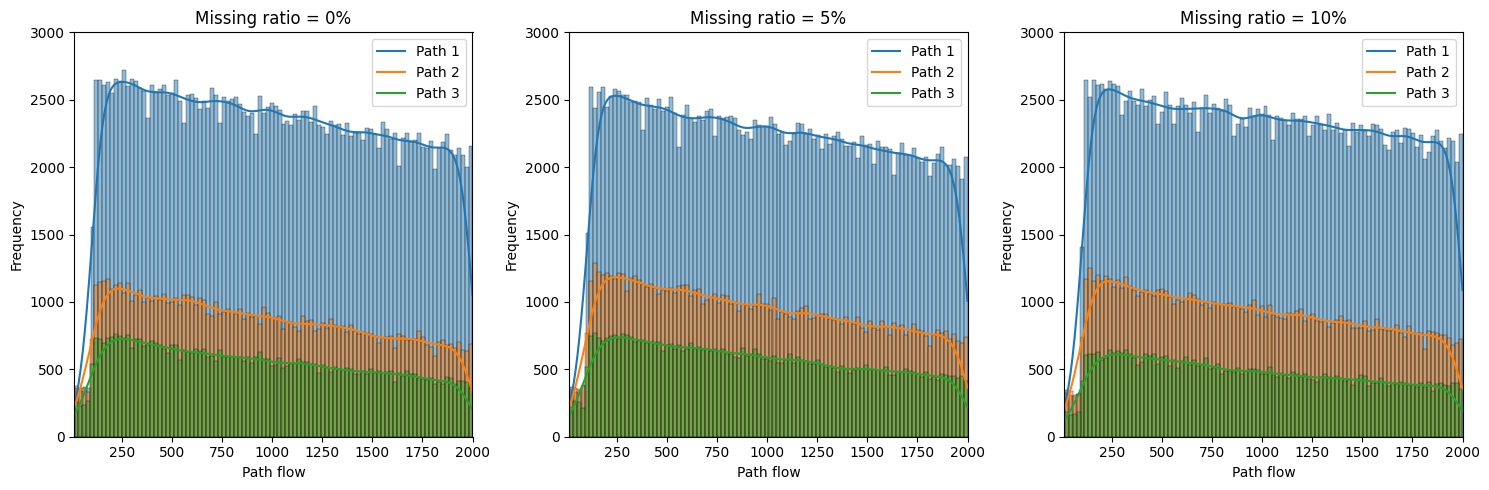

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# f1 = np.array(f1).reshape(-1, 1)
# f2 = np.array(f2).reshape(-1, 1)
# f3 = np.array(f3).reshape(-1, 1)
bins = 20

plt.figure(figsize=(15, 5))
plt.subplot(1,3, 1)
sns.histplot(f1, bins=bins, kde=True, alpha=0.5)
# sns.histplot(f2, bins=bins, kde=True, alpha=0.5)
# sns.histplot(f3, bins=bins, kde=True, alpha=0.5)
sns.histplot(f12, bins=bins, kde=True, alpha=0.5)
sns.histplot(f13, bins=bins, kde=True, alpha=0.3)
# plt.xlim(10, 2000)
# plt.ylim(1500, 2800)
plt.title("1st Path")
plt.xlabel('Path flow')
plt.ylabel('Frequency')
plt.legend(['Missing 0%', 'Missing 5%', 'Missing 10%'])

plt.subplot(1,3, 2)
sns.histplot(f2, bins=bins, kde=True, alpha=0.5)
# sns.histplot(f12, bins=bins, kde=True, alpha=0.5)
sns.histplot(f22, bins=bins, kde=True, alpha=0.5)
# sns.histplot(f32, bins=bins, kde=True, alpha=0.5)
sns.histplot(f23, bins=bins, kde=True, alpha=0.3)
# plt.xlim(10, 2000)
# plt.ylim(300, 1300)
plt.title("2nd Path")
plt.ylabel('Frequency')
plt.xlabel('Path flow')
plt.legend(['Missing 0%', 'Missing 5%', 'Missing 10%'])

plt.subplot(1,3, 3)
sns.histplot(f32, bins=bins, kde=True, alpha=0.5)
sns.histplot(f3, bins=bins, kde=True, alpha=0.5)
# sns.histplot(f13, bins=bins, kde=True, alpha=0.5)
# sns.histplot(f23, bins=bins, kde=True, alpha=0.5)
sns.histplot(f33, bins=bins, kde=True, alpha=0.3)
# plt.xlim(10, 2000)
# plt.ylim(100,800)
plt.title("3rd Path")
plt.ylabel('Frequency')
plt.xlabel('Path flow')
plt.legend(['Missing 5%', 'Missing 0%', 'Missing 10%'])

plt.tight_layout()
plt.show()

/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

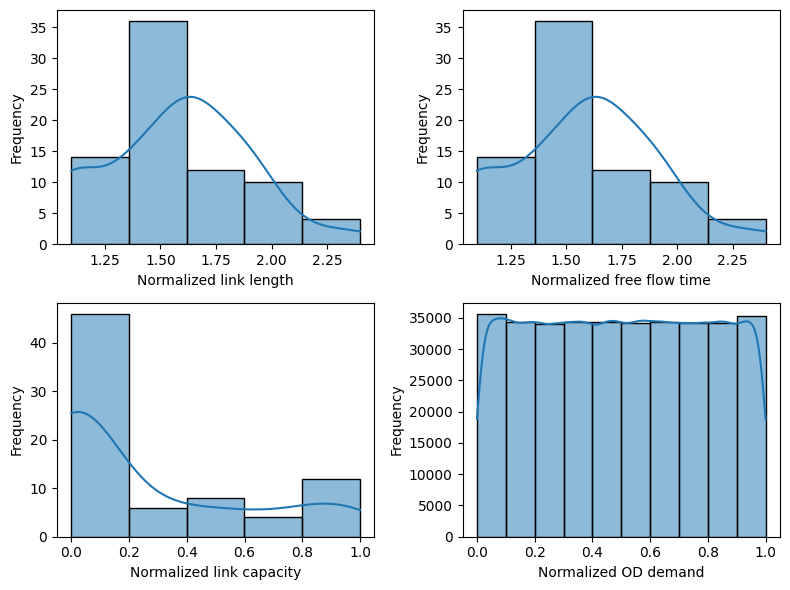

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

stat = read_file('../SiouxFalls/Output1/5by5_Data0')
net = stat["data"]["network"]
cap = net['capacity']
leng = net['length']
fft = net['free_flow_time']
c = np.array(cap).reshape(-1, 1)
f = [j for i in frequence for j in i]
f = np.array(f).reshape(-1, 1)

plt.figure(figsize=(8, 6))

plt.subplot(2,2, 1)
sns.histplot(np.log1p(leng), bins=5, kde=True)
plt.xlabel('Normalized link length')
plt.ylabel('Frequency')

plt.subplot(2,2, 2)
sns.histplot(np.log1p(fft), bins=5, kde=True)
plt.xlabel('Normalized free flow time')
plt.ylabel('Frequency')

plt.subplot(2,2, 3)
sns.histplot(normalize(c).flatten(), bins=5, kde=True)
plt.xlabel('Normalized link capacity')
plt.ylabel('Frequency')

plt.subplot(2,2, 4)
sns.histplot(demand, bins=10, kde=True)
plt.xlabel('Normalized OD demand')
plt.ylabel('Frequency')

# plt.subplot(2,3, 5)
# sns.histplot(normalize(f).flatten(), bins=10, kde=True)
# plt.xlabel('Normalized Link frequency')
# plt.ylabel('Frequency')

# plt.subplot(2,3, 6)
# sns.histplot(od_pair, bins=8, kde=True)
# plt.xlabel('Number of OD pairs')
# plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd

FOLDERS = [f'../SiouxFalls/Output{i}' for i in list([1,2,3])]
DATA_SIZE = 1000

Link_flow, Link_id= [], []
for folder in FOLDERS:
    link_flow, link_id = [], []
    for i in range(DATA_SIZE):
        file = ''.join([folder,str(f'/5by5_Data{i}')])
        stat = read_file(file)
        link_id.append(stat['data']['network']['link_id'])
        link_flow.append(stat['link_flow'])
    Link_flow.append(link_flow)
    Link_id.append(link_id)

/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

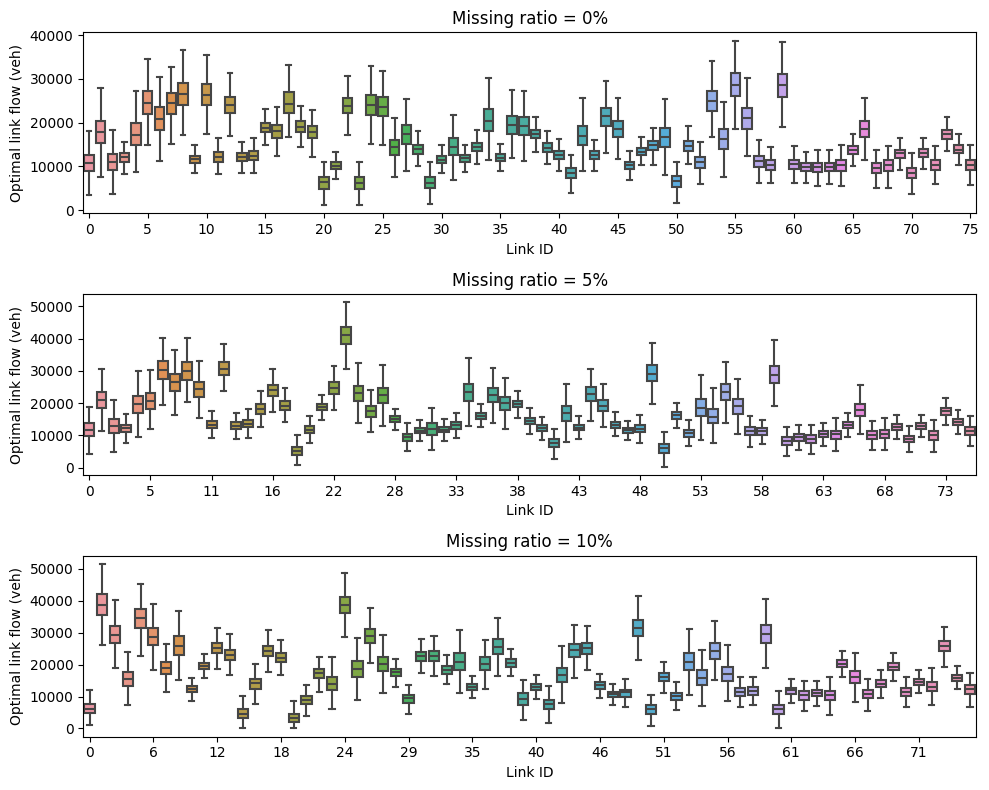

In [12]:
output1 = pd.DataFrame(Link_flow[0], columns=(Link_id[0][0])) # full network
output2 = pd.DataFrame(Link_flow[1], columns=(Link_id[1][0])) # remove 5%
output3 = pd.DataFrame(Link_flow[2], columns=(Link_id[2][0])) # remove 10%

plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
sns.boxplot(data=output1, showfliers=False)
plt.xticks(np.arange(0, 76, step=5)) 
plt.title('Missing ratio = 0%')
plt.ylabel('Optimal link flow (veh)')
plt.xlabel('Link ID')

plt.subplot(3,1,2)
sns.boxplot(data=output2, showfliers=False)
plt.xticks(np.arange(0, 73, step=5)) 
plt.title('Missing ratio = 5%')
plt.ylabel('Optimal link flow (veh)')
plt.xlabel('Link ID')

plt.subplot(3,1,3)
sns.boxplot(data=output3, showfliers=False)
plt.xticks(np.arange(0, 70, step=5)) 
plt.title('Missing ratio = 10%')
plt.ylabel('Optimal link flow (veh)')
plt.xlabel('Link ID')

plt.tight_layout()
plt.show()